# (19) fit — iterative pvae

**Motivation**: host = ```mach```, device = ```cuda:2``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick

device_idx = 2
device = f'cuda:{device_idx}'

## Fit one model

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'jac|lin')

cfg_vae['init_scale'] = 1e-2
cfg_vae['seq_len'] = 5

cfg_tr['lr'] = 2e-3
cfg_tr['epochs'] = 600
cfg_tr['batch_size'] = 500
cfg_tr['kl_beta'] = 3.0
cfg_tr['kl_balancer'] = None

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'vH16', 'n_latents': 512, 'prior_clamp': -4, 'enc_type': 'jac', 'dec_type': 'lin', 'enc_bias': False, 
'dec_bias': False, 'init_dist': 'normal', 'init_scale': 0.01, 'seq_len': 5}

Trainer:
{'batch_size': 500, 'epochs': 600, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500, 'kl_const_portion': 
0.0, 'lr': 0.002, 'kl_beta': 3.0, 'kl_balancer': None}

### Make model + trainer

In [4]:
vae = HIPVAE(CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    HIPVAE   |  132.1 K   |
|     ———     |    ———     |
|  layers.L_0 |  132.1 K   |
+-------------+------------+

poisson_uniform_c(-4)_vH16_t-5_z-[512]_k-32_<jac|lin>
mc_b500-ep600-lr(0.002)_beta(3:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_08_30,17:13)

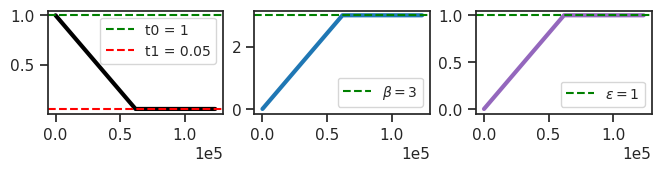

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
print_num_params(vae.input_layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  132.1 K   |
|     ———      |    ———     |
|    fc_dec    |  131.1 K   |
+--------------+------------+

### Fit model

In [7]:
tr.train(fit_name = f"dMSE+LogGain_bal-{tr.cfg.kl_balancer}_{tr.cfg.name()}")

epoch # 600, avg loss: 112.169133: 100%|███████████████████████████████████████████████████████| 600/600 [1:32:01<00:00,  9.20s/it]


epoch # 600, avg loss: 112.833482: 100%|███████████████████████████████████████████████████████| 600/600 [1:41:41<00:00, 10.17s/it]


In [7]:
## Was: w/o kl balancing

epoch # 600, avg loss: 112.833482: 100%|███████████████████████████████████████████████████████| 600/600 [1:59:32<00:00, 11.95s/it]


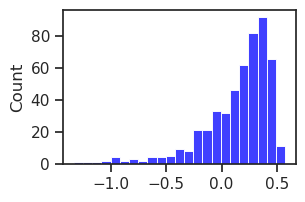

In [10]:
log_rate = tonp(tr.model.input_layer.log_rate).ravel()
sns.histplot(log_rate, color='b');

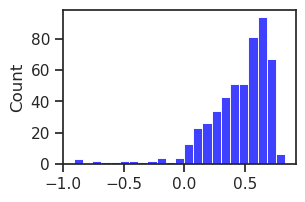

In [14]:
## Was: w/o kl balancing

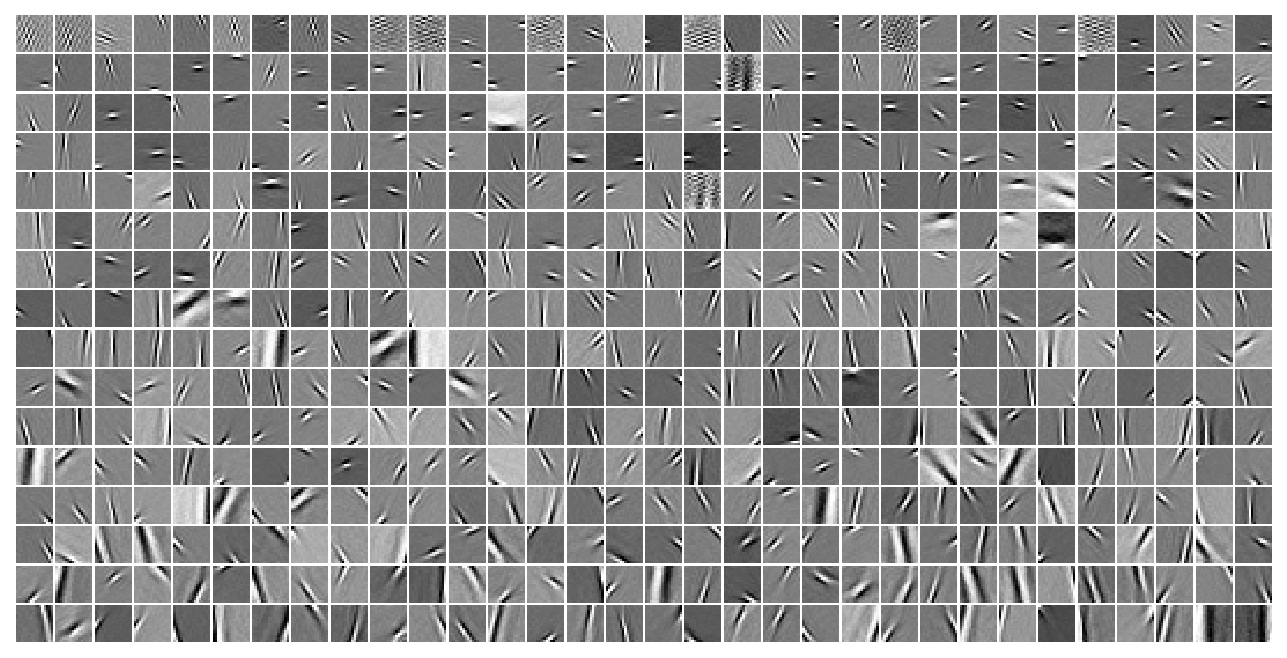

In [11]:
tr.model.show('dec', order=np.argsort(log_rate));

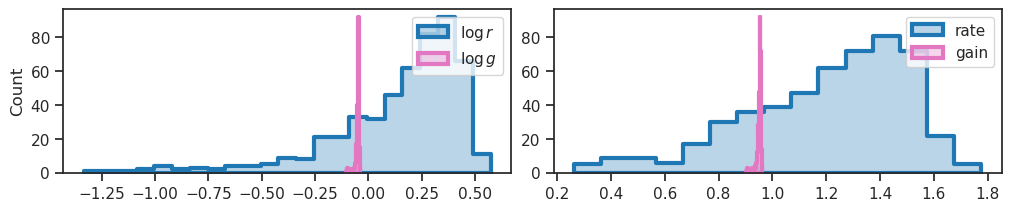

In [12]:
log_rate = tonp(tr.model.input_layer.log_rate).ravel()
log_gain = tonp(tr.model.input_layer.log_gain).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)
sns.histplot(log_gain, color='C6', element='step', label=r'$\log g$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(np.exp(log_gain), color='C6', element='step', label='gain', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

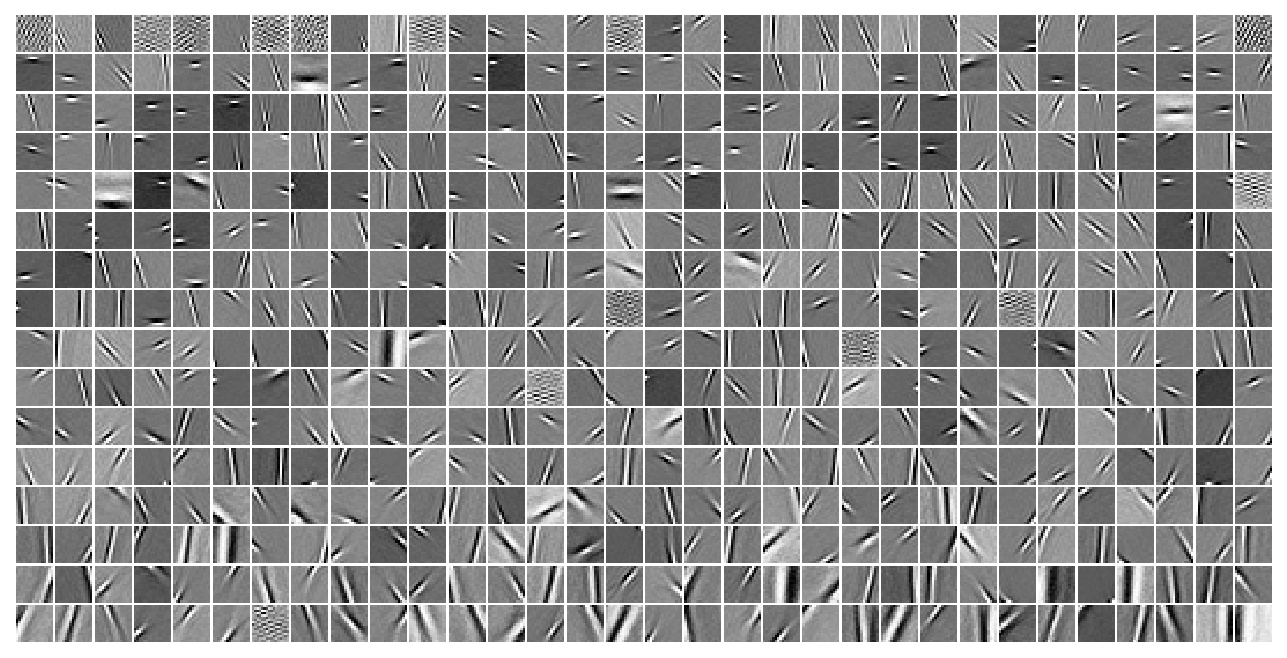

In [15]:
## Was: beta = 3.0, w/o kl balancing

In [13]:
data, loss, etc = tr.validate(full_data=True)
kl_diag = loss['kl_diag'].copy()
loss = {
    k: np.mean(v, 0) for k, v in
    loss.items() if k != 'kl_diag'
}
print(loss)

{
    'kl': array([16.990282 , 14.996777 , 11.224905 ,  7.975634 ,  6.3079743],
      dtype=float32),
    'recon': array([159.52762 , 118.37627 ,  91.511955,  76.24704 ,  67.801445],
      dtype=float32),
    'nelbo': array([176.51768 , 133.37297 , 102.736565,  84.22247 ,  74.1093  ],
      dtype=float32)
}

In [16]:
## Was: beta = 3.0, w/o kl balancing

{
    'kl': array([16.291012, 15.339006, 12.396793,  9.182374,  7.131598],
      dtype=float32),
    'recon': array([161.14883 , 120.11572 ,  91.816086,  75.067474,  65.937584],
      dtype=float32),
    'nelbo': array([177.44064, 135.45453, 104.21298,  84.25013,  73.06952],
      dtype=float32)
}

In [13]:
## Was: beta = 1.0, w/o kl balancing

{
    'kl': array([20.42035 , 19.053827, 14.283528, 10.519677,  8.897385],
      dtype=float32),
    'recon': array([156.59706, 111.6535 ,  85.35357,  72.60118,  66.533  ],
      dtype=float32),
    'nelbo': array([177.01811, 130.70769,  99.63686,  83.12085,  75.43038],
      dtype=float32)
}

In [10]:
## Was: beta = 10.0, w/o kl balancing

{
    'kl': array([1.9436225, 1.7564435, 1.5799026, 1.4234151, 1.2739898],
      dtype=float32),
    'recon': array([185.69737, 179.33975, 173.72878, 168.82994, 164.50043],
      dtype=float32),
    'nelbo': array([187.64114, 181.09625, 175.30927, 170.25317, 165.77448],
      dtype=float32)
}

### Loss

In [14]:
results = tr.analysis(2000, verbose=True)

100%|█████████████████████████████████| 52/52 [06:27<00:00,  7.46s/it]


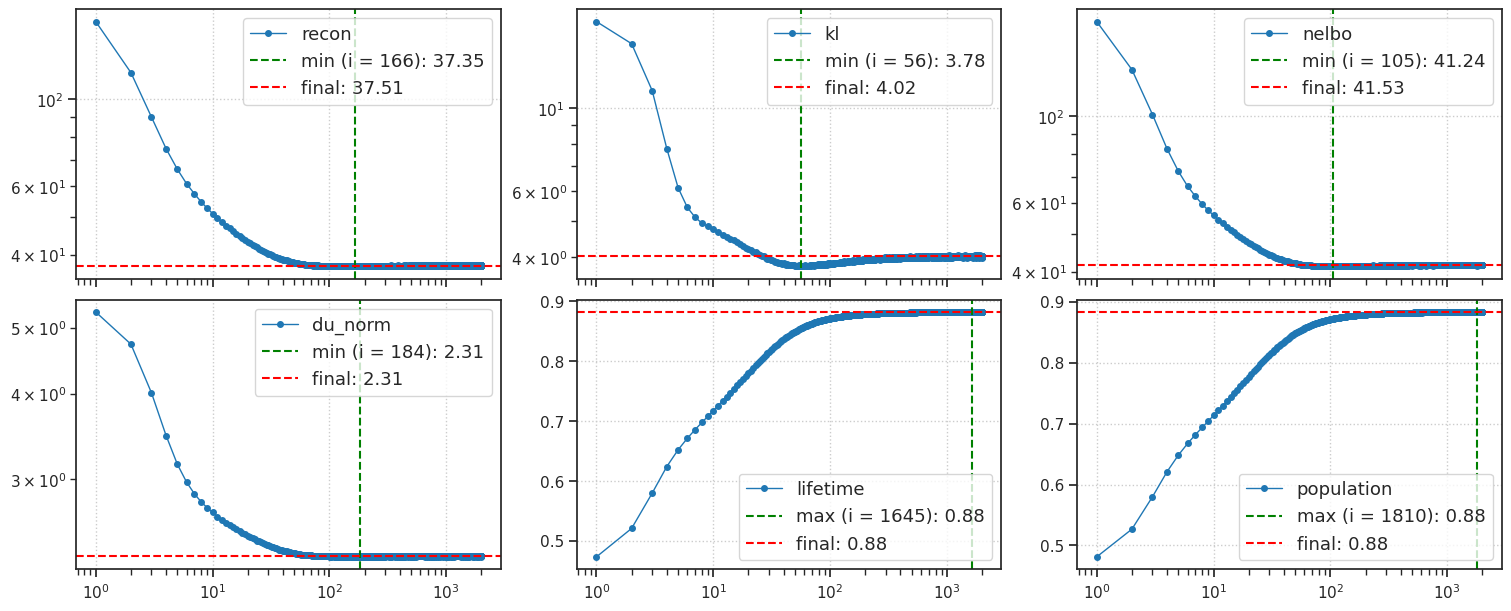

In [15]:
from figures.analysis import plot_convergence
plot_convergence(results)

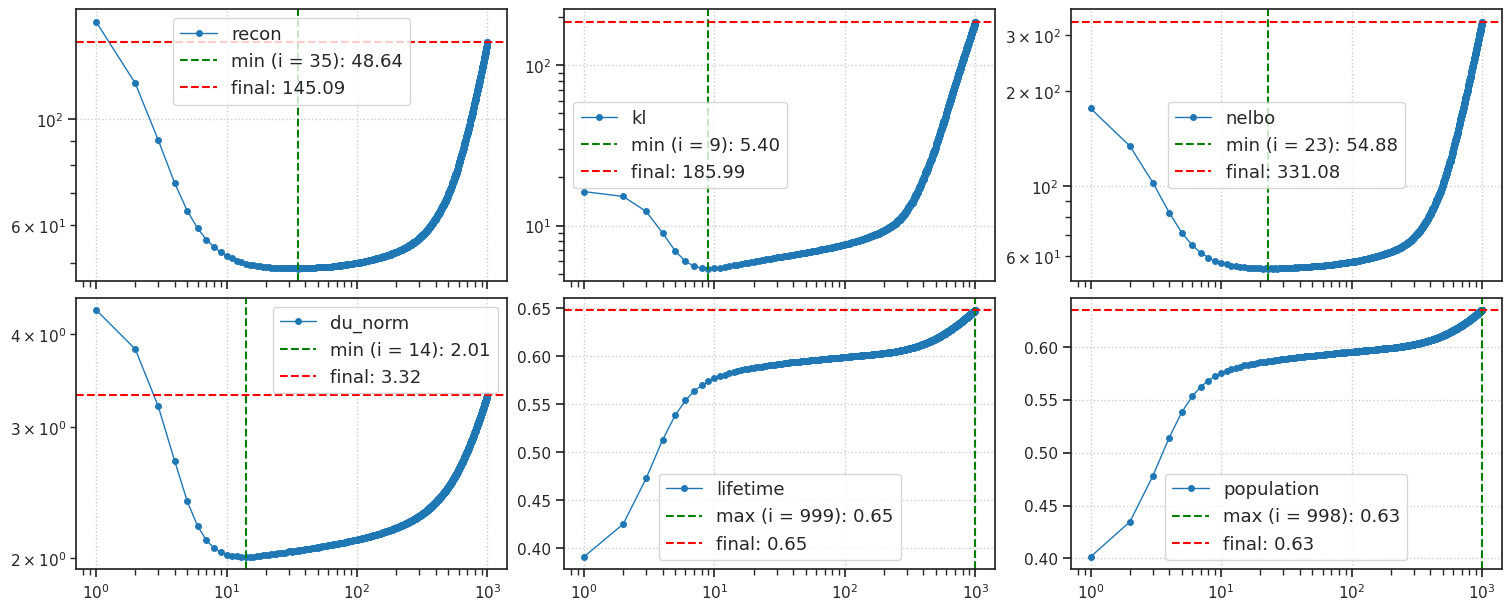

In [13]:
## Was: beta = 1.0

In [12]:
self = tr.model.input_layer
self.reset_state(32)

In [13]:
dist, z, pred = self.generate(0.0)

In [14]:
output = tr.model.xtract_ftr(
    pred, seq=range(300))
output = output.stack()
list(output)

['recon', 'dist', 'spks', 'ff', 'fb', 'loss_kl', 'loss_recon']

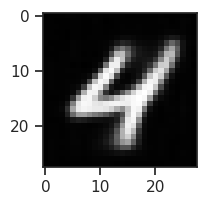

In [43]:
sample_i = 14
x2p = tonp(pred[sample_i, 0])
plt.imshow(x2p, cmap='Greys_r');

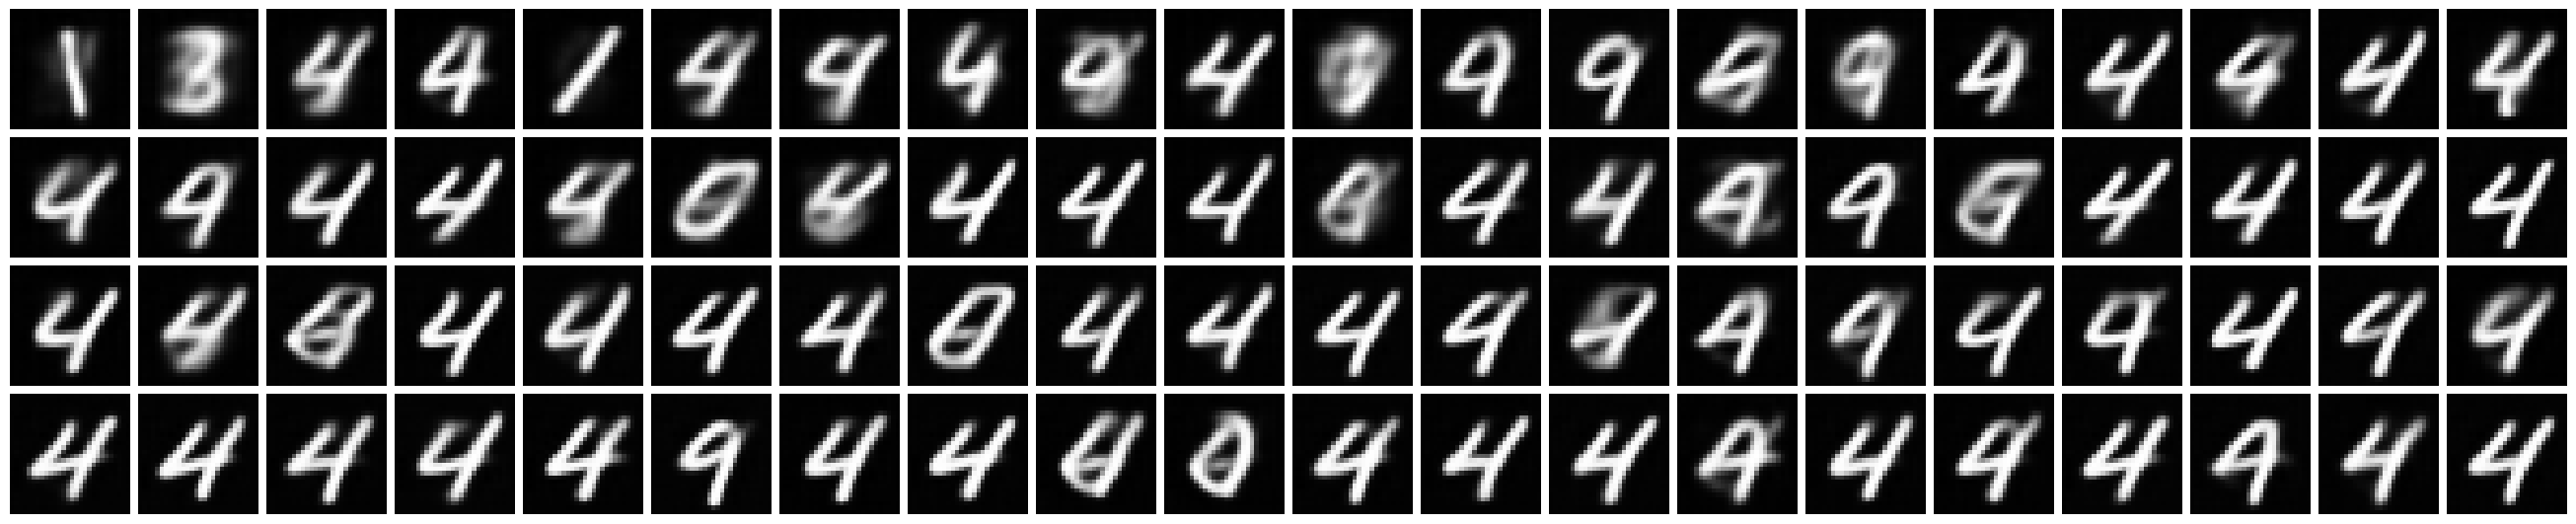

In [50]:
nrows, ncols = 4, 20
fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all')
for idx, ax in enumerate(axes.flat):
    i, j = idx // ncols, idx % ncols
    x2p = tonp(output['recon'][sample_i, idx, 0, ...])
    ax.imshow(x2p, cmap='Greys_r')
remove_ticks(axes)

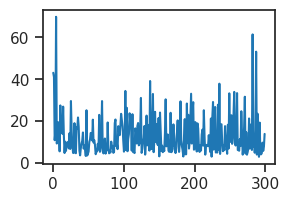

In [48]:
plt.plot(tonp(output['loss_recon'][sample_i]));

## Results produced by:

cfg_vae['lateral_ker_sz'] = None  
cfg_vae['init_scale'] = 1e-5  
cfg_vae['seq_len'] = 20

cfg_tr['lr'] = 2e-3  
cfg_tr['epochs'] = 300  
cfg_tr['batch_size'] = 500  
cfg_tr['kl_beta'] = 80.0  

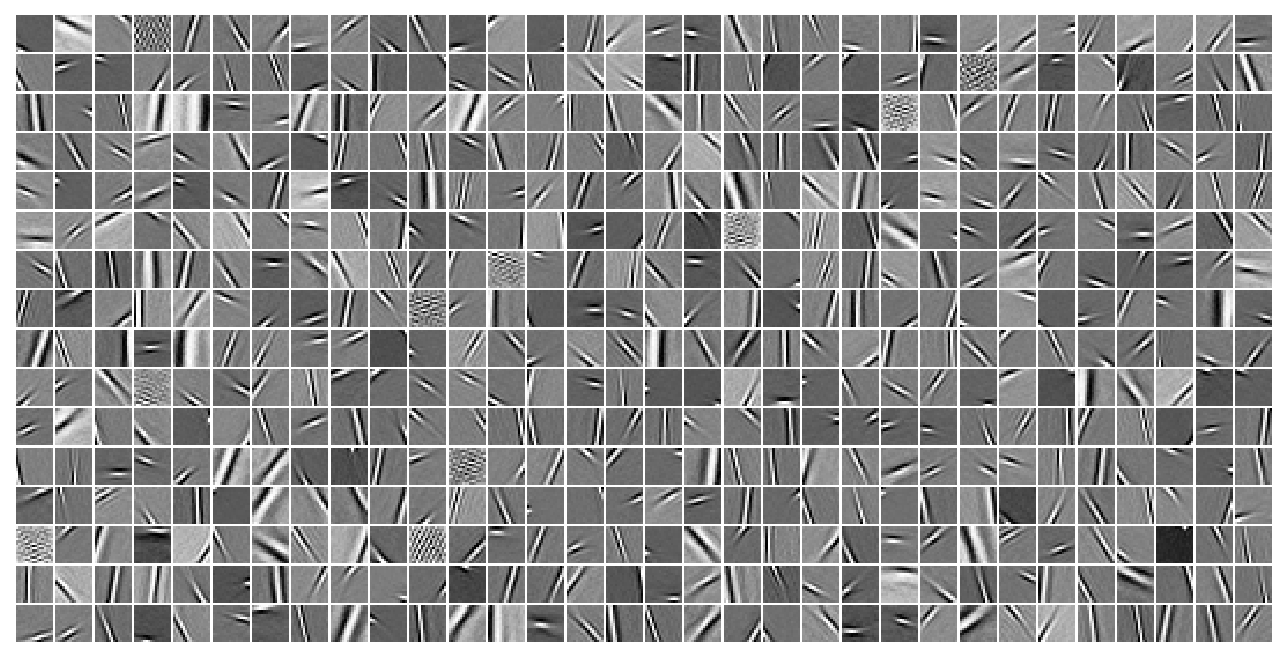

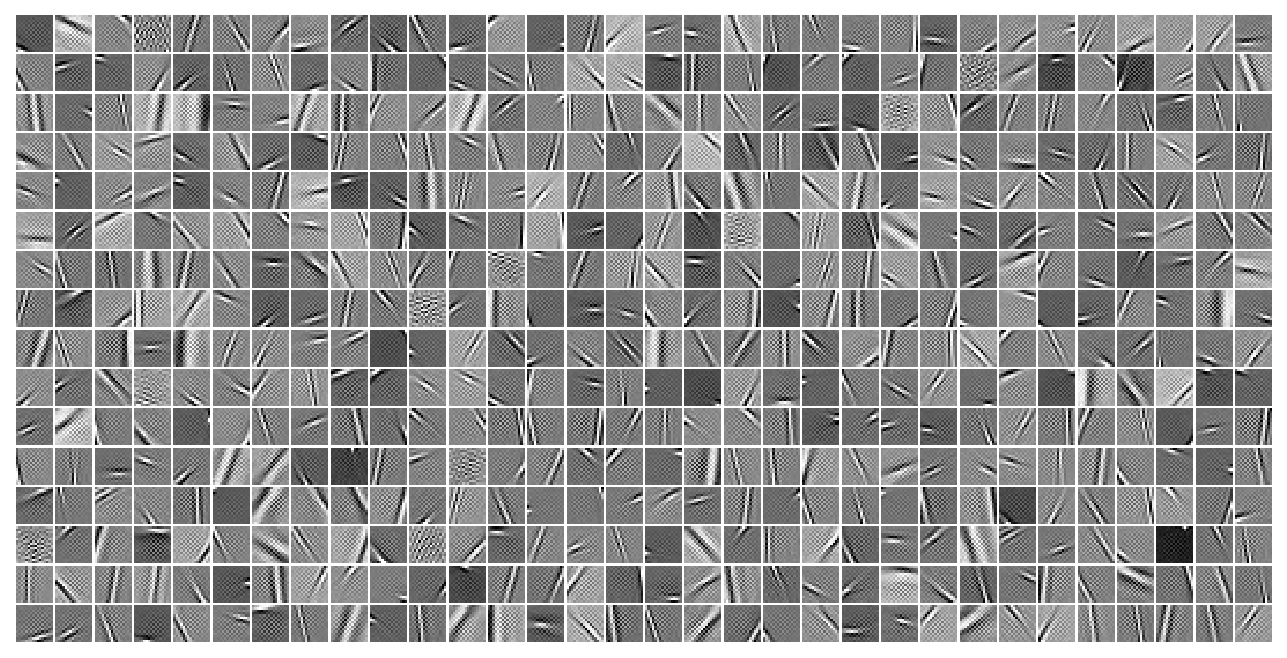

In [23]:
tr.model.show('dec');
tr.model.show('enc');

In [14]:
results = tr.analysis(verbose=True)

100%|█████████████████████████████████| 52/52 [01:54<00:00,  2.21s/it]


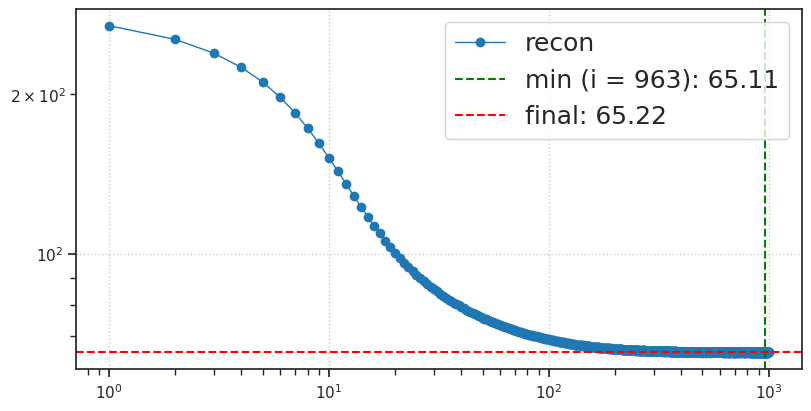

In [17]:
fig, ax = create_figure(1, 1, (8, 4))
ax.plot(range(1, 1 + len(results['recon'])), results['recon'], lw=1, marker='o', label='recon')

min_i = np.argmin(results['recon'])
last = results['recon'][-1]
ax.axvline(min_i + 1, color='g', ls='--', label=f"min (i = {min_i + 1}): {results['recon'][min_i]:0.2f}")
ax.axhline(last, color='r', ls='--', label=f"final: {last:0.2f}")

ax.set(xscale='log', yscale='log')
ax.legend(fontsize=18)
ax.grid()
plt.show()

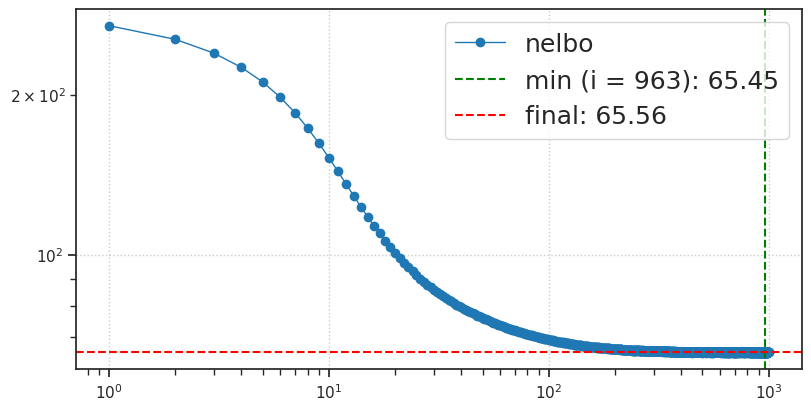

In [18]:
fig, ax = create_figure(1, 1, (8, 4))
ax.plot(range(1, 1 + len(results['nelbo'])), results['nelbo'], lw=1, marker='o', label='nelbo')

min_i = np.argmin(results['nelbo'])
last = results['nelbo'][-1]
ax.axvline(min_i + 1, color='g', ls='--', label=f"min (i = {min_i + 1}): {results['nelbo'][min_i]:0.2f}")
ax.axhline(last, color='r', ls='--', label=f"final: {last:0.2f}")

ax.set(xscale='log', yscale='log')
ax.legend(fontsize=18)
ax.grid()
plt.show()

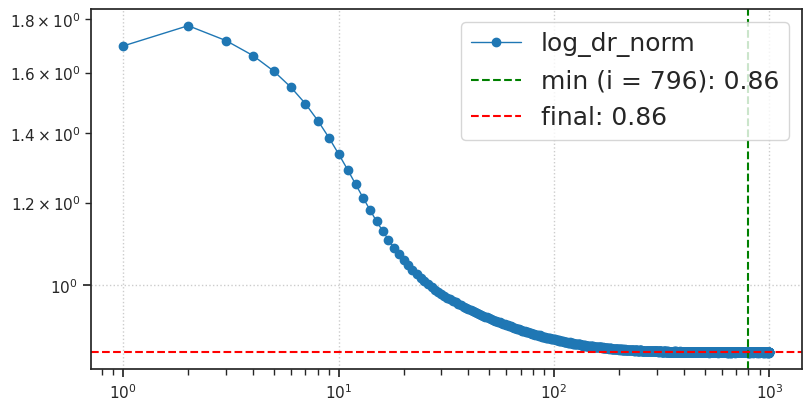

In [19]:
fig, ax = create_figure(1, 1, (8, 4))
ax.plot(range(1, 1 + len(results['log_dr_norm'])), results['log_dr_norm'], lw=1, marker='o', label='log_dr_norm')

min_i = np.argmin(results['log_dr_norm'])
last = results['log_dr_norm'][-1]
ax.axvline(min_i + 1, color='g', ls='--', label=f"min (i = {min_i + 1}): {results['log_dr_norm'][min_i]:0.2f}")
ax.axhline(last, color='r', ls='--', label=f"final: {last:0.2f}")

ax.set(xscale='log', yscale='log')
ax.legend(fontsize=18)
ax.grid()
plt.show()

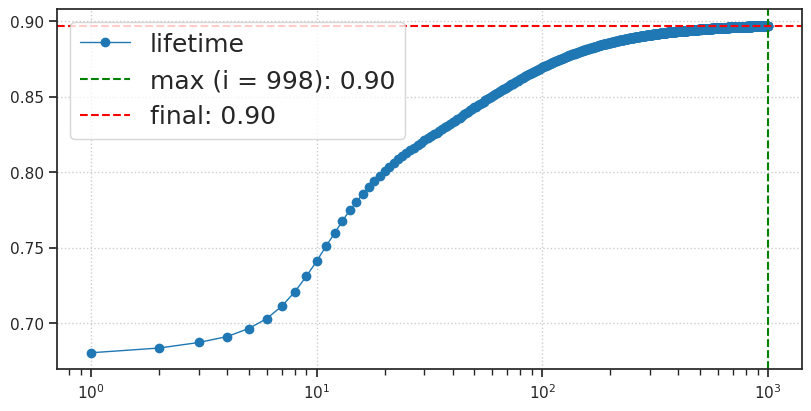

In [20]:
fig, ax = create_figure(1, 1, (8, 4))
ax.plot(range(1, 1 + len(results['lifetime'])), results['lifetime'], lw=1, marker='o', label='lifetime')

max_i = np.argmax(results['lifetime'])
last = results['lifetime'][-1]
ax.axvline(max_i - 1, color='g', ls='--', label=f"max (i = {max_i - 1}): {results['lifetime'][max_i]:0.2f}")
ax.axhline(last, color='r', ls='--', label=f"final: {last:0.2f}")

ax.set(xscale='log', yscale='linear')
ax.legend(fontsize=18)
ax.grid()
plt.show()

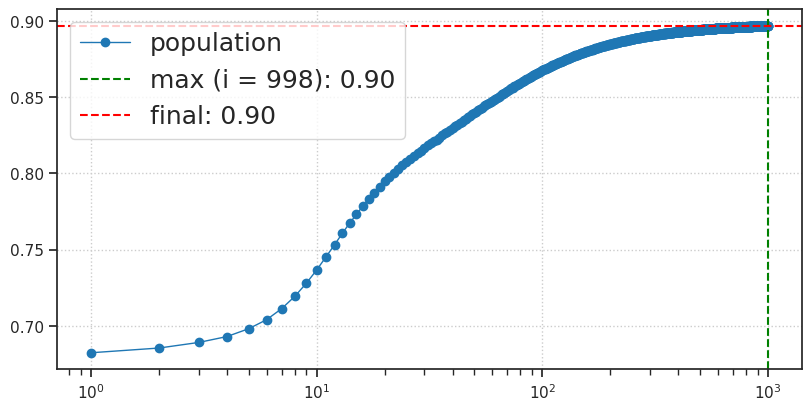

In [21]:
fig, ax = create_figure(1, 1, (8, 4))
ax.plot(range(1, 1 + len(results['population'])), results['population'], lw=1, marker='o', label='population')

max_i = np.argmax(results['population'])
last = results['population'][-1]
ax.axvline(max_i - 1, color='g', ls='--', label=f"max (i = {max_i - 1}): {results['population'][max_i]:0.2f}")
ax.axhline(last, color='r', ls='--', label=f"final: {last:0.2f}")

ax.set(xscale='log', yscale='linear')
ax.legend(fontsize=18)
ax.grid()
plt.show()